#**PIA: Entrenamiento de una red neuronal convolucional.**
#**Identificar diez clases de animales.**

**2127803 José Antonio Martínez Calan IMC**

**Cargar librerías**

In [58]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import os
import cv2
from collections import defaultdict
import random
import matplotlib.pyplot as plt
from google.colab import files

**Importar conjunto de datos**

*Instalar la librería de Kaggle*

In [10]:
!pip install kaggle

*Subir el archivo kaggle.json*

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joanmartcal","key":"37202173817e21f63624f399c4f7f898"}'}

*Configurar el archivo kaggle.json*

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

*Descargar el dataset Animals-10 desde Kaggle*

In [5]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


*Generar ruta de descarga y descompresión*

In [6]:
zip_file_path = '/content/animals10.zip'
extracted_folder_path = '/content/Animals10'

*Descomprimir el archivo*

In [7]:
import zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)
print(f"Dataset descomprimido en: {extracted_folder_path}")

Dataset descomprimido en: /content/Animals10


**Preprocesamiento**

*Verificar resoluciones de imágenes.*

In [16]:

# Variables
resolution_counts = defaultdict(int)
folder_count = 0
image_count = 0
resolutions = []
base_path = '/content/Animals10/raw-img'
# Recorrer las carpetas e imágenes
for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)
    if os.path.isdir(folder_path):  # ver si es una carpeta
        folder_count += 1
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                img = cv2.imread(file_path)
                if img is not None:
                    image_count += 1
                    resolution = img.shape[:2]
                    resolutions.append(resolution)
                    resolution_counts[resolution] += 1
            except Exception as e:
                print(f"Error al procesar la imagen: {file_path}. Error: {e}")

# resolución más baja
if resolutions:
    min_resolution = min(resolutions, key=lambda x: x[0] * x[1])  # Resolución con menos píxeles
else:
    min_resolution = None

# resultado
print(f"Carpetas recorridas: {folder_count}")
print(f"Total de imágenes analizadas: {image_count}")
print("Resumen de resoluciones:")
for resolution, count in resolution_counts.items():
    print(f"Resolución {resolution}: {count} imágenes")

if min_resolution:
    print(f"\nResolución más baja: {min_resolution} (Total píxeles: {min_resolution[0] * min_resolution[1]})")
else:
    print("\nNo se encontraron imágenes.")

print(f"\nTotal de resoluciones únicas: {len(resolution_counts)}")


Carpetas recorridas: 10
Total de imágenes analizadas: 26179
Resumen de resoluciones:
Resolución (225, 300): 4397 imágenes
Resolución (640, 500): 1 imágenes
Resolución (198, 300): 63 imágenes
Resolución (300, 300): 1192 imágenes
Resolución (426, 640): 694 imágenes
Resolución (221, 300): 299 imágenes
Resolución (209, 300): 111 imágenes
Resolución (223, 300): 104 imágenes
Resolución (199, 300): 586 imágenes
Resolución (251, 300): 90 imágenes
Resolución (428, 640): 53 imágenes
Resolución (201, 300): 288 imágenes
Resolución (200, 300): 3281 imágenes
Resolución (300, 282): 57 imágenes
Resolución (222, 300): 71 imágenes
Resolución (300, 257): 14 imágenes
Resolución (483, 640): 2 imágenes
Resolución (255, 300): 48 imágenes
Resolución (217, 300): 67 imágenes
Resolución (194, 270): 44 imágenes
Resolución (188, 300): 393 imágenes
Resolución (219, 300): 118 imágenes
Resolución (415, 640): 6 imágenes
Resolución (228, 300): 111 imágenes
Resolución (630, 640): 1 imágenes
Resolución (207, 300): 99 imá

*Ver orden real de las carpetas y elementos guardados en ellas.*

In [27]:
ruta_base = '/content/Animals10/raw-img'
def contar_imagenes_por_carpeta(ruta_base):
    conteo = {}
    formatos_imagen = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    for carpeta in os.listdir(ruta_base):
        carpeta_path = os.path.join(ruta_base, carpeta)

        if os.path.isdir(carpeta_path):
            num_imagenes = len([f for f in os.listdir(carpeta_path) if any(f.endswith(ext) for ext in formatos_imagen)])
            conteo[carpeta] = num_imagenes
    return conteo
conteo = contar_imagenes_por_carpeta(ruta_base)
for carpeta, num_imagenes in conteo.items():
    print(f"Carpeta: {carpeta} -> {num_imagenes} imágenes")


Carpeta: farfalla -> 2112 imágenes
Carpeta: mucca -> 1866 imágenes
Carpeta: pecora -> 1820 imágenes
Carpeta: elefante -> 1446 imágenes
Carpeta: scoiattolo -> 1862 imágenes
Carpeta: gallina -> 3098 imágenes
Carpeta: ragno -> 4821 imágenes
Carpeta: cavallo -> 2623 imágenes
Carpeta: gatto -> 1668 imágenes
Carpeta: cane -> 4863 imágenes


*Bajar resolución de imágenes.*

In [28]:
input_path = '/content/Animals10/raw-img'
output_path = '/content/Animals10/resized-images'
target_resolution = (57, 60)
os.makedirs(output_path, exist_ok=True)
for folder_name in os.listdir(input_path):
    folder_path = os.path.join(input_path, folder_name)
    if os.path.isdir(folder_path):
        output_folder_path = os.path.join(output_path, folder_name)
        os.makedirs(output_folder_path, exist_ok=True)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            output_file_path = os.path.join(output_folder_path, file_name)
            try:
                img = cv2.imread(file_path)
                if img is not None:
                    resized_img = cv2.resize(img, (target_resolution[1], target_resolution[0]))
                    cv2.imwrite(output_file_path, resized_img)
            except Exception as e:
                print(f"Error al redimensionar la imagen: {file_path}. Error: {e}")
print(f"Todas las imágenes han sido redimensionadas a la resolución: {target_resolution} (altura, ancho)")
print(f"Imágenes guardadas en: {output_path}")

Todas las imágenes han sido redimensionadas a la resolución: (57, 60) (altura, ancho)
Imágenes guardadas en: /content/Animals10/resized-images


*Crear vectores "x" y "y".*

In [29]:
x = []
y = []
ClasesName = ['mariposa','vaca','oveja','elefante','ardilla','gallina','araña','caballo','gato','perro']  # Cambia estos nombres a las clases correctas

for folder_index, folder_name in enumerate(os.listdir(input_path)):
    folder_path = os.path.join(input_path, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                img = cv2.imread(file_path)
                if img is not None:
                    img_resized = cv2.resize(img, (57, 60))
                    x.append(img_resized)
                    y.append(folder_index)
            except Exception as e:
                print(f"Error al procesar la imagen: {file_path}. Error: {e}")

# Convertir x a un arreglo de NumPy
x = np.array(x)
y = np.array(y)

print(f"Total de imágenes en X: {len(x)}")
print(f"Total de clases en Y: {len(y)}")


Total de imágenes en X: 26179
Total de clases en Y: 26179


In [30]:
x.shape

(26179, 60, 57, 3)

In [31]:
y.shape

(26179,)

*Probar vectores.*

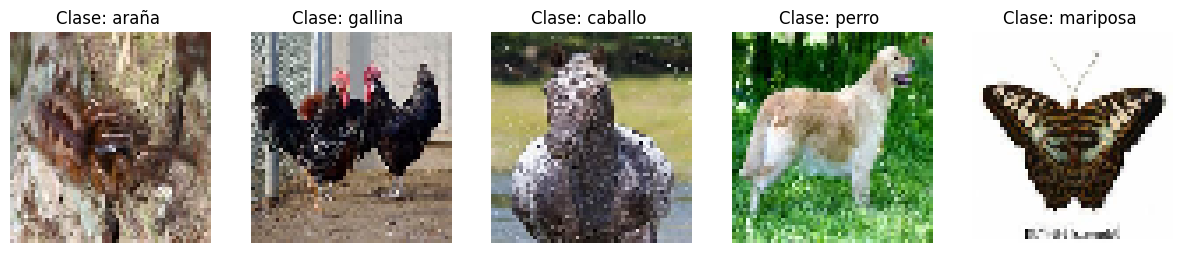

In [43]:
num_images = 5
indices = random.sample(range(len(x)), num_images)
plt.figure(figsize=(15, 5))

for i, idx in enumerate(indices):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(cv2.cvtColor(x[idx], cv2.COLOR_BGR2RGB))
    plt.title(f"Clase: {ClasesName[y[idx]]} ")
    plt.axis('off')

plt.show()

**Creación de red neuronal y entrenamiento.**

*Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)*

In [44]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

*Dividir el 20% restante en validación (10%) y prueba (10%)*

In [45]:
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

*Normalizar datos*

In [46]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

*Crear red.*

In [47]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 57, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(47, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 58, 55, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 29, 27, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 11, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 47)                  │           6,063 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 509,039 (1.94 MB)

 Trainable params: 509,039 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

*Compilamos el modelo*

In [49]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

*Entrenar Red*

In [50]:
history = model.fit(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 142s 214ms/step - accuracy: 0.2796 - loss: 2.0832 - val_accuracy: 0.4840 - val_loss: 1.5258
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 160s 242ms/step - accuracy: 0.5155 - loss: 1.4232 - val_accuracy: 0.5577 - val_loss: 1.2926
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 178s 206ms/step - accuracy: 0.5993 - loss: 1.1737 - val_accuracy: 0.6108 - val_loss: 1.1573
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 139s 201ms/step - accuracy: 0.6665 - loss: 0.9848 - val_accuracy: 0.6325 - val_loss: 1.0942
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 141s 200ms/step - accuracy: 0.7190 - loss: 0.8400 - val_accuracy: 0.6318 - val_loss: 1.1056
Epoch 6/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 134s 204ms/step - accuracy: 0.7567 - loss: 0.7252 - val_accuracy: 0.6658 - val_loss: 1.0111
Epoch 7/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 132s 201ms/step - accuracy: 0.7997 - loss: 0.5922 - val_accuracy: 0.6383 - val_loss: 1.1705
Epoch 8/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 138s 195ms/step - accuracy: 0.8429 -

*Verificar exactitud del entrenamiento.*

In [51]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Precisión en el conjunto de prueba: {test_acc:.2f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.6738 - loss: 1.2630
Precisión en el conjunto de prueba: 0.67


**Validación del modelo**

*Gráfico de precisión y pérdida*

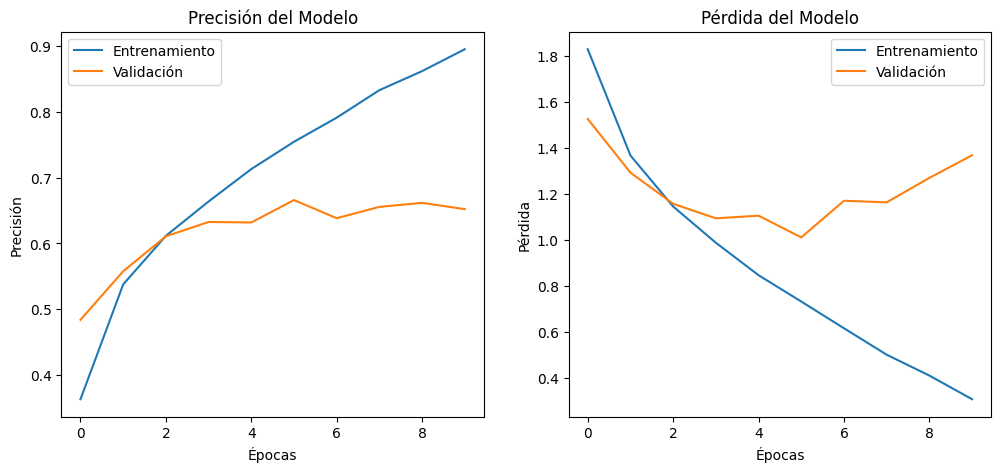

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión del Modelo')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida del Modelo')

plt.show()

*Predicciones de prueba.*

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


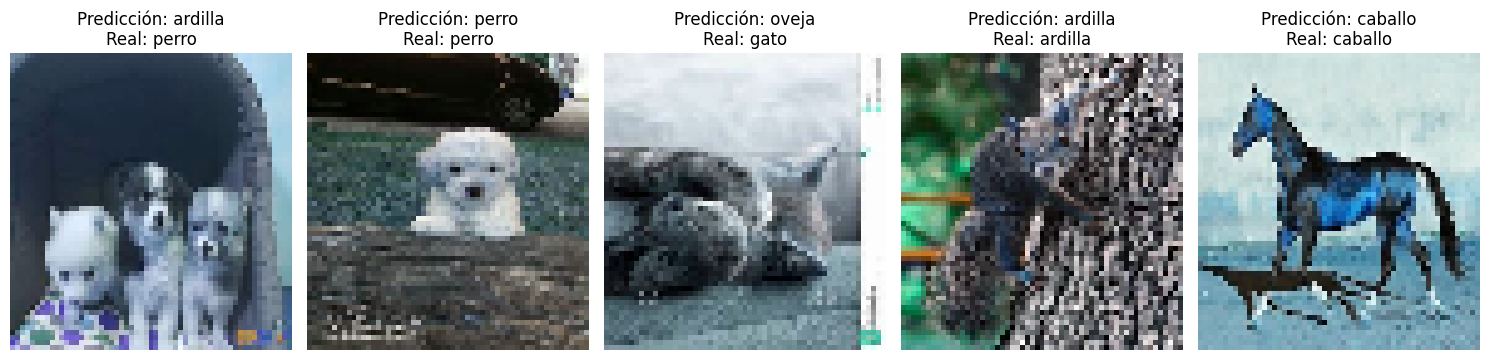

In [59]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    image = x_test[i].reshape(1, 60, 57, 3)
    prediction = model.predict(image)
    predicted_label = np.argmax(prediction)
    actual_label = y_test[i]
    axes[i].imshow(x_test[i])
    axes[i].set_title(f"Predicción: {ClasesName[predicted_label]}\nReal: {ClasesName[actual_label]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()